# 02b-splicebert_embeddings-training_set_non_human.ipynb: Nucleotide embedding analysis for HBV and host splicing patterns (fine-tuning without human splice sites)
Extracts nucleotide embeddings, applies dimensionality reduction, and performs clustering to uncover splice site sequence patterns in both HBV and host genomes.

Clustering splice donor sites

In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sys
import os
import logging

scripts_dir = os.path.abspath(os.path.join(os.getcwd(), '../scripts'))

if scripts_dir not in sys.path:
    sys.path.append(scripts_dir)

from splicebert_helpers import cal_metric_by_group
from dicts import ssdict, sslab, ssize

In [2]:
# Spliceator training set without human splice sites (nonhs)

splicebert_ss = sc.read_h5ad("../data/processed_files/splicebert_donor/consensus_splice_sites_nonhs.SpliceBERT.L6.GT.h5ad")
splicebert_ss.obs["label"] = splicebert_ss.obs["label"].apply(lambda x: ssdict[x])
splicebert_ss.obs["splice site"] = splicebert_ss.obs["name"].apply(lambda x: sslab[x])
splicebert_ss.obs["size"] = splicebert_ss.obs["name"].apply(lambda x: ssize[x])

# Re-run leiden with different resolutions
resolutions = [0.2, 0.4, 0.6, 0.8]

for res in resolutions:
    print(f"\nRunning leiden with resolution = {res}...")
    sc.tl.leiden(splicebert_ss, resolution=res, key_added=f'leiden_res_{res:.1f}', flavor="igraph", n_iterations=2, directed=False)
    print(f"Number of clusters for resolution {res}: {splicebert_ss.obs[f'leiden_res_{res:.1f}'].nunique()}")

# Fix splice sites that are caused by indels
splicebert_ss.obs["label"] = splicebert_ss.obs["label"].astype(str)
splicebert_ss.obs.loc[splicebert_ss.obs.coordinate.str.contains(":3413-3415"), "label"] = "GU (HBV non-donor)"
splicebert_ss.obs["label"] = splicebert_ss.obs["label"].astype("category")
splicebert_ss.obs.loc[splicebert_ss.obs.coordinate.str.contains(":3413-3415"), "size"] = 10

splicebert_ss.obs.loc[splicebert_ss.obs.coordinate.str.contains(":3375-3377"), "label"] = "GU (HBV non-donor)"
splicebert_ss.obs["label"] = splicebert_ss.obs["label"].astype("category")
splicebert_ss.obs.loc[splicebert_ss.obs.coordinate.str.contains(":3375-3377"), "size"] = 10

splicebert_ss.write_h5ad("../data/processed_files/splicebert_donor/consensus_splice_sites_nonhs.SpliceBERT.L6.GT.res.h5ad")


Running leiden with resolution = 0.2...
Number of clusters for resolution 0.2: 19

Running leiden with resolution = 0.4...
Number of clusters for resolution 0.4: 23

Running leiden with resolution = 0.6...
Number of clusters for resolution 0.6: 33

Running leiden with resolution = 0.8...
Number of clusters for resolution 0.8: 39


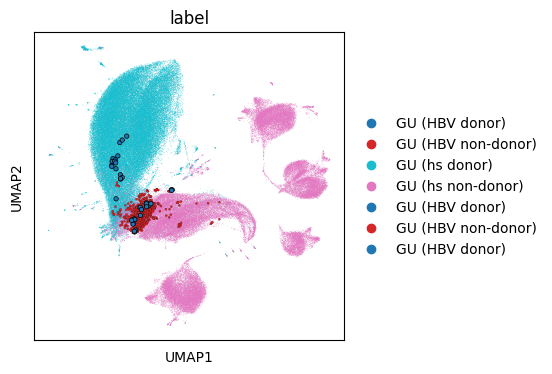

<Figure size 640x480 with 0 Axes>

In [2]:
splicebert_ss = sc.read_h5ad("../data/processed_files/splicebert_donor/consensus_splice_sites_nonhs.SpliceBERT.L6.GT.res.h5ad")

fig, ax = plt.subplots(figsize=(4, 4))

sc.pl.umap(splicebert_ss, ax=ax, 
           color="label", size=0.5, show=False, palette=['#1f77b4', '#d62728', '#17becf', '#e377c2'])

sc.pl.umap(splicebert_ss[splicebert_ss.obs["label"].str.contains("HBV")], 
           size=10, show=False, ax=ax, edgecolor='black', linewidths=0.1, 
           color="label")

sc.pl.umap(splicebert_ss[splicebert_ss.obs["size"]==100], ax=ax, 
           color="label", size=40, edgecolor='black', linewidths=0.5)

plt.tight_layout()
fig.savefig("../results/figures/fig2/umap.donor.png", bbox_inches='tight', dpi=300)

In [3]:
lclus = splicebert_ss.obs[(splicebert_ss.obs.label.str.contains("HBV")) & (splicebert_ss.obs.label.str.contains("donor"))][["leiden_res_0.4"]].drop_duplicates()
dclus = pd.merge(splicebert_ss.obs.reset_index(), lclus).set_index("index")
dclus = splicebert_ss[dclus.index].copy()

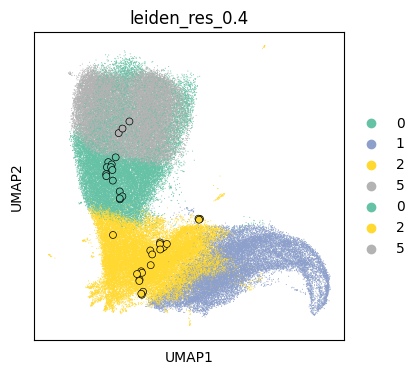

<Figure size 640x480 with 0 Axes>

In [4]:
fig, ax = plt.subplots(figsize=(4, 4))

sc.pl.umap(dclus, ax=ax, 
           color="leiden_res_0.4", size=2, show=False, palette="Set2")

sc.pl.umap(dclus[dclus.obs["size"]==100].copy(), ax=ax, 
           color="leiden_res_0.4", size=100, edgecolor='black', linewidths=0.5)

plt.tight_layout()
fig.savefig("../results/figures/fig2/umap.donors.leiden.png", bbox_inches='tight', dpi=300)

In [4]:
splicebert_ss.obs.value_counts("label")

label
GU (hs donor)         95323
GU (hs non-donor)     80542
GU (HBV non-donor)      627
GU (HBV donor)           41
Name: count, dtype: int64

Calculate NMIs

In [5]:
donors = ['GU (donor)', 'GU (non-donor)']

cal_metric_by_group(splicebert_ss.obs["splice site"], splicebert_ss.obs["leiden_res_0.4"], donors=donors)

0.37921830820283714

In [6]:
donors = ['GU (hs donor)', 'GU (hs non-donor)']

cal_metric_by_group(dclus.obs["label"], dclus.obs["leiden_res_0.4"], donors=donors)

0.40857340668855224

In [7]:
donors = ['GU (HBV non-donor)', 'GU (HBV donor)']

cal_metric_by_group(dclus.obs["label"], dclus.obs["leiden_res_0.4"], donors=donors)

0.2600297935554716

Calculate percent true labels

In [8]:
crosstab_donors = pd.crosstab(index=dclus.obs["leiden_res_0.4"], columns=dclus.obs['splice site'])
crosstab_donors_perc = crosstab_donors.div(crosstab_donors.sum(axis=1), axis=0)

In [9]:
splice_vars = []

for i in lclus["leiden_res_0.4"].tolist():
    splice_var = ",".join(dclus.obs[(dclus.obs["leiden_res_0.4"]==i) & (dclus.obs.label.str.contains("HBV"))]["name2"].unique()).split(",")
    splice_var = list(set(splice_var))
    splice_vars.append([i, splice_var])
    
splice_vars = pd.DataFrame(splice_vars)
splice_vars.columns = ["leiden_res_0.4","HBV splice variants"]

crosstab_donors_perc = pd.merge(crosstab_donors_perc.reset_index(), splice_vars)
crosstab_donors_perc.to_pickle("../data/processed_files/crosstab_donors_perc_nonhs.pkl.gz")
crosstab_donors_perc

,leiden_res_0.4,GU (donor),GU (non-donor),HBV splice variants
0,0,0.991005,0.008995,"[pSP11, SP18, SP13, pSP7, SP9, SP7, SP6, pSP10..."
1,1,0.042589,0.957411,[none]
2,2,0.377237,0.622763,"[none, SP5, SP4]"
3,5,0.999392,0.000608,"[SP18, SP7, pSP8, SP14, pSP12]"


Clustering splice acceptor sites

In [2]:
# Spliceator training set without human splice sites (nonhs)

splicebert_ss = sc.read_h5ad("../data/processed_files/splicebert_acceptor/consensus_splice_sites_nonhs.SpliceBERT.L6.AG.h5ad")
splicebert_ss.obs["label"] = splicebert_ss.obs["label"].apply(lambda x: ssdict[x])
splicebert_ss.obs["splice site"] = splicebert_ss.obs["name"].apply(lambda x: sslab[x])
splicebert_ss.obs["size"] = splicebert_ss.obs["name"].apply(lambda x: ssize[x])

# Re-run leiden with different resolutions
resolutions = [0.2, 0.4, 0.6, 0.8]

for res in resolutions:
    print(f"\nRunning leiden with resolution = {res}...")
    sc.tl.leiden(splicebert_ss, resolution=res, key_added=f'leiden_res_{res:.1f}', flavor="igraph", n_iterations=2, directed=False)
    print(f"Number of clusters for resolution {res}: {splicebert_ss.obs[f'leiden_res_{res:.1f}'].nunique()}")

# Fix splice sites that are caused by indels
splicebert_ss.obs["label"] = splicebert_ss.obs["label"].astype(str)
splicebert_ss.obs.loc[splicebert_ss.obs.coordinate.str.contains(":3431-3433"), "label"] = "AG (HBV non-acceptor)"
splicebert_ss.obs.loc[splicebert_ss.obs.coordinate.str.contains(":3431-3433"), "size"] = 10

splicebert_ss.obs.loc[splicebert_ss.obs.coordinate.str.contains(":3394-3396"), "label"] = "AG (HBV non-acceptor)"
splicebert_ss.obs.loc[splicebert_ss.obs.coordinate.str.contains(":3394-3396"), "size"] = 10

splicebert_ss.obs["label"] = splicebert_ss.obs["label"].astype("category")

splicebert_ss.write_h5ad("../data/processed_files/splicebert_acceptor/consensus_splice_sites_nonhs.SpliceBERT.L6.AG.res.h5ad")


Running leiden with resolution = 0.2...
Number of clusters for resolution 0.2: 21

Running leiden with resolution = 0.4...
Number of clusters for resolution 0.4: 30

Running leiden with resolution = 0.6...
Number of clusters for resolution 0.6: 35

Running leiden with resolution = 0.8...
Number of clusters for resolution 0.8: 47


In [10]:
sns.color_palette("tab10").as_hex()

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

In [11]:
print(sns.color_palette("tab10").as_hex())

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


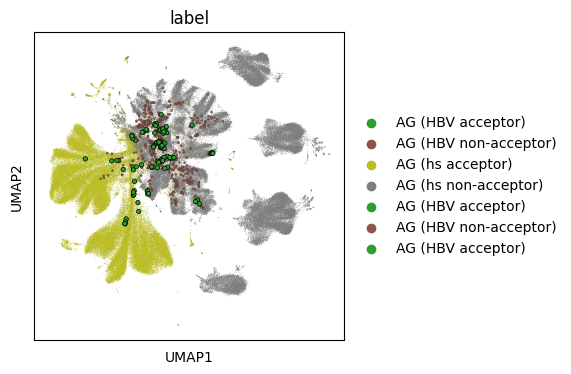

<Figure size 640x480 with 0 Axes>

In [10]:
splicebert_ss = sc.read_h5ad("../data/processed_files/splicebert_acceptor/consensus_splice_sites_nonhs.SpliceBERT.L6.AG.res.h5ad")

fig, ax = plt.subplots(figsize=(4, 4))

sc.pl.umap(splicebert_ss, ax=ax, 
           color="label", size=0.5, show=False, palette=['#2ca02c', '#8c564b', '#bcbd22', '#7f7f7f'])

sc.pl.umap(splicebert_ss[splicebert_ss.obs["label"].str.contains("HBV")], 
           size=10, show=False, ax=ax, edgecolor='black', linewidths=0.1, 
           color="label")

sc.pl.umap(splicebert_ss[splicebert_ss.obs["size"]==100], ax=ax, 
           color="label", size=40, edgecolor='black', linewidths=0.5)

plt.tight_layout()
fig.savefig("../results/figures/fig2/umap.acceptor.png", bbox_inches='tight', dpi=300)

In [11]:
lclus = splicebert_ss.obs[(splicebert_ss.obs.label.str.contains("HBV")) & (splicebert_ss.obs.label.str.contains("acceptor"))][["leiden_res_0.4"]].drop_duplicates()
aclus = pd.merge(splicebert_ss.obs.reset_index(), lclus).set_index("index")
aclus = splicebert_ss[aclus.index].copy()

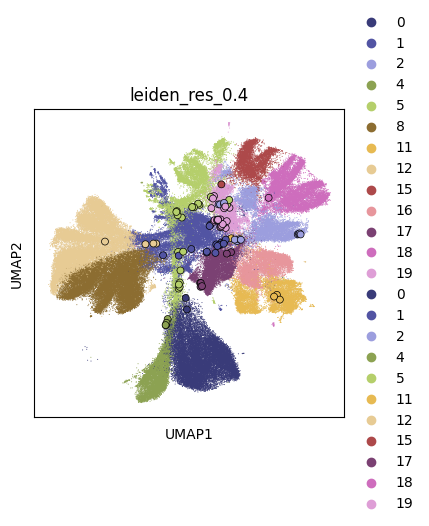

<Figure size 640x480 with 0 Axes>

In [12]:
fig, ax = plt.subplots(figsize=(4, 4))

sc.pl.umap(aclus, ax=ax, 
           color="leiden_res_0.4", size=2, show=False, palette="tab20b")

sc.pl.umap(aclus[aclus.obs["size"]==100].copy(), ax=ax, 
           color="leiden_res_0.4", size=100, edgecolor='black', linewidths=0.5)

plt.tight_layout()
fig.savefig("../results/figures/fig2/umap.acceptor.leiden.png", bbox_inches='tight', dpi=300)

In [7]:
splicebert_ss.obs.value_counts("label")

label
AG (hs non-acceptor)     123162
AG (hs acceptor)          99179
AG (HBV non-acceptor)       529
AG (HBV acceptor)            94
Name: count, dtype: int64

##### Calculcate acceptor NMI

In [13]:
acceptors = ['AG (acceptor)', 'AG (non-acceptor)']

cal_metric_by_group(splicebert_ss.obs["splice site"], splicebert_ss.obs["leiden_res_0.4"], acceptors=acceptors)

0.3068041910863687

In [14]:
acceptors = ['AG (hs acceptor)', 'AG (hs non-acceptor)']

cal_metric_by_group(aclus.obs["label"], aclus.obs["leiden_res_0.4"], acceptors=acceptors)

0.30735892575791307

In [15]:
acceptors = ['AG (HBV acceptor)', 'AG (HBV non-acceptor)']

cal_metric_by_group(aclus.obs["label"], aclus.obs["leiden_res_0.4"], acceptors=acceptors)

0.051775923519434296

Calculcate percent true labels

In [16]:
crosstab_acceptors = pd.crosstab(index=aclus.obs["leiden_res_0.4"], columns=aclus.obs['splice site'])
crosstab_acceptors_perc = crosstab_acceptors.div(crosstab_acceptors.sum(axis=1), axis=0)

In [17]:
splice_vars = []

for i in lclus["leiden_res_0.4"].tolist():
    splice_var = ",".join(aclus.obs[(aclus.obs["leiden_res_0.4"]==i) & (aclus.obs.label.str.contains("HBV"))]["name2"].unique()).split(",")
    splice_var = list(set(splice_var))
    splice_vars.append([i, splice_var])
    
splice_vars = pd.DataFrame(splice_vars)
splice_vars.columns = ["leiden_res_0.4","HBV splice variants"]

crosstab_acceptors_perc = pd.merge(crosstab_acceptors_perc.reset_index(), splice_vars)
crosstab_acceptors_perc.to_pickle("../data/processed_files/crosstab_acceptors_perc_nonhs.pkl.gz")
crosstab_acceptors_perc

,leiden_res_0.4,AG (acceptor),AG (non-acceptor),HBV splice variants
0,0,0.996285,0.003715,[none]
1,1,0.541090,0.458910,"[none, pSP9]"
2,2,0.106166,0.893834,"[SP18, SP13, SP7, pSP8, none]"
3,4,0.998418,0.001582,"[SP18, SP7, SP6, SP14, SP1, SP4, SP5]"
4,5,0.379267,0.620733,"[pSP11, SP9, pSP8, pSP10, none, pSP9, SP11, pS..."
5,8,0.995394,0.004606,[none]
6,11,0.064293,0.935707,[none]
7,12,0.997361,0.002639,[none]
8,15,0.037052,0.962948,[none]
9,16,0.052596,0.947404,[none]


##### Compare percent typical splice sites with Leiden clusters

In [18]:
d = crosstab_donors_perc.explode("HBV splice variants")
d.drop("GU (non-donor)", axis=1, inplace=True)
d.columns = ["leiden_donor","GU (donor)","HBV splice variants"]

a = crosstab_acceptors_perc.explode("HBV splice variants")
a.drop("AG (non-acceptor)", axis=1, inplace=True)
a.columns = ["leiden_acceptor","AG (acceptor)","HBV splice variants"]

In [19]:
conss = pd.read_csv("../data/processed_files/consensus_splice_sites.bed.gz", sep="\t", header=None)
conss.columns = ["chrom","start","end","name","name2","strand"]
conss["coordinate"] = conss["chrom"] + ":" + conss["start"].astype(str) + "-" + conss["end"].astype(str)

dclus = dclus.obs.drop(["leiden_res_0.2","leiden_res_0.6","leiden_res_0.8"], axis=1).rename(columns = {"leiden_res_0.4":"leiden_res"})
aclus = aclus.obs.drop(["leiden_res_0.2","leiden_res_0.6","leiden_res_0.8"], axis=1).rename(columns = {"leiden_res_0.4":"leiden_res"})

conss = pd.merge(conss, pd.concat([dclus, aclus]))
conss.to_csv("../data/processed_files/conss_nonhs.bed", sep="\t", index=None, header=None)

In [1]:
! bedtools intersect -a <(grep -v SRR ../data/processed_files/conss_nonhs.bed) -b <(bed12ToBed6 -i ../ref/gencode.v41lift37.annotation.bed) -wo -s \
    | bedtools intersect -a stdin -b ../ref/utr.hs.bed -v \
    | awk '!seen[$7]++' | cut -f10,12 | sort | uniq -c | sort -k2,2g \
    | awk '{print $4 "\t" $2,$3 "\t" $1}' > ../data/processed_files/conss_nonhs.cds.stats

! bedtools intersect -a <(grep -v SRR ../data/processed_files/conss_nonhs.bed) -b <(bed12ToBed6 -i ../ref/gencode.v41lift37.annotation.bed) -wao -s \
    | bedtools intersect -a stdin -b ../ref/utr.hs.bed -v \
    | awk '!seen[$7]++' | cut -f10,12 | sort | uniq -c | sort -k2,2g \
    | awk '{print $4 "\t" $2,$3 "\t" $1}' > ../data/processed_files/conss_nonhs.all.stats

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

In [2]:
conss_cds_stats = pd.read_csv("../data/processed_files/conss_nonhs.cds.stats", sep="\t", header=None)
conss_cds_stats.columns = ["Leiden cluster","Splice site","Number of exonic splice sites"]
conss_all_stats = pd.read_csv("../data/processed_files/conss_nonhs.all.stats", sep="\t", header=None)
conss_all_stats.columns = ["Leiden cluster","Splice site","Total number of splice sites"]

conss_stats = pd.merge(conss_cds_stats, conss_all_stats)
conss_stats["% Typical splice sites"] = 100-(conss_stats["Number of exonic splice sites"]/conss_stats["Total number of splice sites"]*100)

In [4]:
crosstab_donors_perc = pd.read_pickle("../data/processed_files/crosstab_donors_perc_nonhs.pkl.gz")
crosstab_donors_perc.rename(columns = {"leiden_res_0.4":"leiden_res"}, inplace=True)
crosstab_acceptors_perc = pd.read_pickle("../data/processed_files/crosstab_acceptors_perc_nonhs.pkl.gz")
crosstab_acceptors_perc.rename(columns = {"leiden_res_0.4":"leiden_res"}, inplace=True)

cdp = crosstab_donors_perc[["leiden_res","GU (donor)"]].copy()
cdp["Splice site"] = "GU (donor)"
cdp.columns = ["Leiden cluster","% True label","Splice site"]
cap = crosstab_acceptors_perc[["leiden_res","AG (acceptor)"]].copy()
cap["Splice site"] = "AG (acceptor)"
cap.columns = ["Leiden cluster","% True label","Splice site"]

In [5]:
crosstab_stats = pd.concat([cdp,cap])
crosstab_stats["Leiden cluster"] = crosstab_stats["Leiden cluster"].astype(int)
crosstab_stats["% True label"] = crosstab_stats["% True label"]*100

cstats = pd.merge(crosstab_stats, conss_stats)
cstats.to_pickle("../data/processed_files/cstats_nonhs.pkl.gz")

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

cstats = pd.read_pickle("../data/processed_files/cstats_nonhs.pkl.gz")
cstats["Splice site"] = cstats["Splice site"].str.replace("GU (donor)","Donor site").str.replace("AG (acceptor)","Acceptor site")

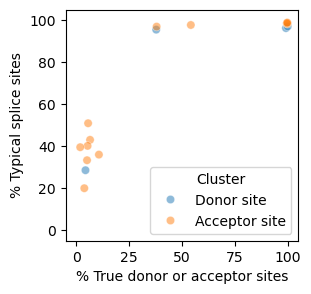

In [7]:
plt.figure(figsize=(3,3))

ax = sns.scatterplot(data=cstats, x="% True label", y="% Typical splice sites", 
            hue="Splice site", alpha=0.5)

plt.xlabel('% True donor or acceptor sites')
plt.ylabel('% Typical splice sites')
plt.legend(title="Cluster")
plt.xlim(-5,105)
plt.ylim(-5,105)
sns.move_legend(ax, "lower right")
plt.savefig("../results/figures/fig3/typical_splice_sites.png", bbox_inches='tight', dpi=300)

In [8]:
spearmanr(cstats["% Typical splice sites"], cstats["% True label"])

SignificanceResult(statistic=0.8897058823529412, pvalue=1.7498572958917092e-06)

Map coSI scores to exonic CDS splice sites

In [9]:
! cut -f-6,12 ../data/processed_files/conss_nonhs.bed \
    | bedtools window -a stdin -b ../data/huh7/intron.zeta.pUC57.bed -l 1 -r 1 \
    | awk 'BEGIN{FS="\t"} (/hg19_donor/ && $6~/+/ && $2==($9+1)) || (/hg19_acceptor/ && $6~/+/ && $3==($10-1))' | cut -f-7,11,12 \
    | bedtools intersect -a stdin -b <(bed12ToBed6 -i ../ref/gencode.v41lift37.annotation.bed) -wo -s \
    | awk '!seen[$1,$2,$3,$4,$5,$6,$7]++' > ../data/processed_files/exonicss_nonhs.txt

! cat ../data/processed_files/intron.zeta.bed ../data/huh7/intron.zeta.bed | awk '!/NA/' \
    | datamash -g 1,2,3,6 -s median 4,5 \
    | awk 'BEGIN{OFS="\t"} {print $1,$2,$3,$5,$6,$4}' \
    | bedtools window \
    -a <(sed 's/_/\t/' ../data/processed_files/conss_nonhs.bed | awk 'BEGIN{FS=OFS="\t"} /HBV/ {print $1,$3-255,$4-255,$5,$6,$7,$13}') \
    -b stdin -l 1 -r 1 | awk 'BEGIN{FS="\t"} ($6~/+/ && $2==($9+1)) || ($6~/+/ && $3==($10-1))'  | cut -f-7,11,12 \
    | awk '!seen[$1,$2,$3,$4,$5,$6,$7]++' > ../data/processed_files/exonicss_nonhs.hbv.txt

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

exonicss = pd.read_csv("../data/processed_files/exonicss_nonhs.txt", header=None, sep="\t")
exonicss = exonicss.rename(columns={6:"leiden_res",7:"coSI 3'",8:"coSI 5'"})
exonicss["transcriptome"] = "hs"

exonicss_hbv = pd.read_csv("../data/processed_files/exonicss_nonhs.hbv.txt", header=None, sep="\t")
exonicss_hbv = exonicss_hbv.rename(columns={6:"leiden_res",7:"coSI 3'",8:"coSI 5'"})
exonicss_hbv["transcriptome"] = "HBV"

exonicss = pd.concat([exonicss, exonicss_hbv]).reset_index(drop=True)
exonicss.value_counts([3])

3                  
AG(hg19_acceptor)      2628
GT(hg19_donor)         2201
AG(C2_acceptor)           8
AG(B2_acceptor)           7
AG(D3_acceptor)           6
AG(B2_non-acceptor)       5
GT(B2_donor)              5
GT(C2_donor)              5
AG(A2_acceptor)           4
GT(A2_donor)              4
GT(D3_donor)              4
GT(B2_non-donor)          3
AG(C2_non-acceptor)       2
AG(D3_non-acceptor)       1
GT(D3_non-donor)          1
Name: count, dtype: int64

In [2]:
d = exonicss[exonicss[3].str.contains("donor")].copy()
d = pd.merge(d, d[d.transcriptome=="HBV"][["leiden_res"]].drop_duplicates())

a = exonicss[exonicss[3].str.contains("acceptor")].copy()
a = pd.merge(a, a[a.transcriptome=="HBV"][["leiden_res"]].drop_duplicates())

In [3]:
from decimal import Decimal, ROUND_HALF_UP, ROUND_FLOOR, ROUND_CEILING

crosstab_donors_perc = pd.read_pickle("../data/processed_files/crosstab_donors_perc_nonhs.pkl.gz")
crosstab_donors_perc.rename(columns = {"leiden_res_0.4":"leiden_res"}, inplace=True)
crosstab_donors_perc["GU (donor)"] = crosstab_donors_perc["GU (donor)"].apply(lambda x: Decimal(str(x)).quantize(Decimal('0.10'), rounding=ROUND_HALF_UP))
crosstab_donors_perc["% Splice donor"] = crosstab_donors_perc["GU (donor)"].apply(lambda x: x*100).astype(int).astype(str)
crosstab_donors_perc["leiden_res"] = crosstab_donors_perc.leiden_res.astype(int)
crosstab_donors_perc = pd.merge(crosstab_donors_perc, d[d.transcriptome=="HBV"][["leiden_res"]].drop_duplicates())

crosstab_acceptors_perc = pd.read_pickle("../data/processed_files/crosstab_acceptors_perc_nonhs.pkl.gz")
crosstab_acceptors_perc.rename(columns = {"leiden_res_0.4":"leiden_res"}, inplace=True)
crosstab_acceptors_perc["AG (acceptor)"] = crosstab_acceptors_perc["AG (acceptor)"].apply(lambda x: Decimal(str(x)).quantize(Decimal('0.10'), rounding=ROUND_HALF_UP))
crosstab_acceptors_perc["% Splice acceptor"] = crosstab_acceptors_perc["AG (acceptor)"].apply(lambda x: x*100).astype(int).astype(str)
crosstab_acceptors_perc["leiden_res"] = crosstab_acceptors_perc.leiden_res.astype(int)
crosstab_acceptors_perc = pd.merge(crosstab_acceptors_perc, a[a.transcriptome=="HBV"][["leiden_res"]].drop_duplicates())

In [4]:
from scipy.stats import spearmanr

crosstab_donors_perc["leiden_res"] = crosstab_acceptors_perc["leiden_res"].astype(int)
dc = pd.merge(d[~d["coSI 5'"].isna()].groupby("leiden_res")["coSI 5'"].apply(np.median).reset_index(), crosstab_donors_perc.rename(columns={"GU (donor)":"proportion of splice site"}))

crosstab_acceptors_perc["leiden_res"] = crosstab_acceptors_perc["leiden_res"].astype(int)
ac = pd.merge(a[~a["coSI 3'"].isna()].groupby("leiden_res")["coSI 3'"].apply(np.median).reset_index(), crosstab_acceptors_perc.rename(columns={"AG (acceptor)":"proportion of splice site"}))

ssc = pd.concat([dc.rename(columns={"coSI 5'":"coSI"}), ac.rename(columns={"coSI 3'":"coSI"})])

spearmanr(ssc.coSI, ssc["proportion of splice site"])

SignificanceResult(statistic=0.8099999999999998, pvalue=0.0025077180298861274)

In [4]:
sns.color_palette("Set2").as_hex()

['#66c2a5',
 '#fc8d62',
 '#8da0cb',
 '#e78ac3',
 '#a6d854',
 '#ffd92f',
 '#e5c494',
 '#b3b3b3']

In [5]:
print(sns.color_palette("Set2").as_hex())

['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494', '#b3b3b3']


In [6]:
# Create colour palette indices
dpsp1 = d[(d.transcriptome=="HBV") & (d[4].str.contains("none"))].copy()
dpsp2 = d[(d.transcriptome=="HBV") & (~d[4].str.contains(r"none|,SP|^SP"))].copy()
dpsp = pd.concat([dpsp1,dpsp2])

dsp = pd.concat([dpsp,d[(d.transcriptome=="HBV")]]).drop_duplicates(keep=False)
dsp_idx = dsp["leiden_res"].sort_values().unique()
dpsp_idx = dpsp["leiden_res"].sort_values().unique()
d_idx = np.unique(np.concatenate([dsp_idx, dpsp_idx])).tolist()

pal = ['#66c2a5','#ffd92f','#b3b3b3']
pal_dict = dict(zip(d_idx, pal))

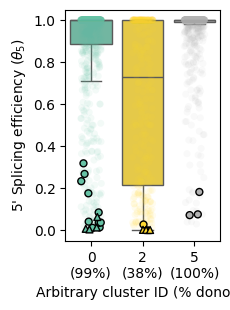

In [7]:
plt.figure(figsize=(2,3))

g = sns.boxplot(data=d, x="leiden_res", y="coSI 5'", hue="leiden_res", palette=pal, showfliers=False, legend=False)
g = sns.stripplot(data=d[d.transcriptome=="hs"], x="leiden_res", y="coSI 5'", hue="leiden_res", palette=pal,
                  linewidth=0, alpha=0.08, jitter=0.2, legend=False)
g = sns.stripplot(data=dsp, x="leiden_res", y="coSI 5'", hue="leiden_res", palette=[pal_dict[i] for i in dsp_idx], 
                  edgecolor='black', linewidth=1, jitter=0.2, legend=False)
g = sns.stripplot(data=dpsp, x="leiden_res", y="coSI 5'", hue="leiden_res", palette=[pal_dict[i] for i in dpsp_idx], 
                  edgecolor='black', marker="^", linewidth=1, jitter=0.2, legend=False)

plt.xlabel("Arbitrary cluster ID (% donors)") # (splice donor sites)")#
plt.ylabel(r"5' Splicing efficiency ($\theta_5$)")

g.set_xticks(range(crosstab_donors_perc.shape[0]))
g.set_xticklabels(crosstab_donors_perc["leiden_res"].astype(str) + "\n(" + (crosstab_donors_perc["% Splice donor"].astype(str) + "%)"))

plt.savefig("../results/figures/fig3/cosi_donor.leiden.png", bbox_inches='tight',dpi=300)

In [8]:
print(sns.color_palette("tab20b").as_hex())

['#393b79', '#5254a3', '#6b6ecf', '#9c9ede', '#637939', '#8ca252', '#b5cf6b', '#cedb9c', '#8c6d31', '#bd9e39', '#e7ba52', '#e7cb94', '#843c39', '#ad494a', '#d6616b', '#e7969c', '#7b4173', '#a55194', '#ce6dbd', '#de9ed6']


In [9]:
sns.color_palette("tab20b").as_hex()

['#393b79',
 '#5254a3',
 '#6b6ecf',
 '#9c9ede',
 '#637939',
 '#8ca252',
 '#b5cf6b',
 '#cedb9c',
 '#8c6d31',
 '#bd9e39',
 '#e7ba52',
 '#e7cb94',
 '#843c39',
 '#ad494a',
 '#d6616b',
 '#e7969c',
 '#7b4173',
 '#a55194',
 '#ce6dbd',
 '#de9ed6']

In [10]:
apsp1 = a[(a.transcriptome=="HBV") & (a[4].str.contains("none"))].copy()
apsp2 = a[(a.transcriptome=="HBV") & (~a[4].str.contains(r"none|,SP|^SP"))].copy()
apsp = pd.concat([apsp1,apsp2])

asp = pd.concat([apsp,a[(a.transcriptome=="HBV")]]).drop_duplicates(keep=False)
asp_idx = asp["leiden_res"].sort_values().unique()
apsp_idx = apsp["leiden_res"].sort_values().unique()
a_idx = np.unique(np.concatenate([asp_idx, apsp_idx])).tolist()

pal =[ "#393b79","#5254a3","#9c9ede","#8ca252","#b5cf6b","#8c6d31","#e7cb94","#ce6dbd","#de9ed6"]
pal_dict = dict(zip(a_idx, pal))

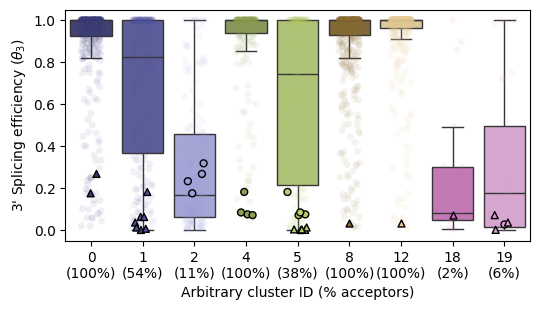

In [11]:
plt.figure(figsize=(6,3))

g = sns.boxplot(data=a, x="leiden_res", y="coSI 3'", hue="leiden_res", 
                palette=pal, showfliers=False, legend=False)
g = sns.stripplot(data=a[a.transcriptome=="hs"], x="leiden_res", y="coSI 3'", hue="leiden_res", 
                  palette=pal, alpha=0.08, jitter=0.2, legend=False)
g = sns.stripplot(data=asp, x="leiden_res", y="coSI 5'", hue="leiden_res", 
                  palette=[pal_dict[i] for i in asp_idx], edgecolor='black', linewidth=1, jitter=0.2, legend=False)
g = sns.stripplot(data=apsp, x="leiden_res", y="coSI 5'", hue="leiden_res", 
                  palette=[pal_dict[i] for i in apsp_idx], marker="^", edgecolor='black', linewidth=1, jitter=0.2, legend=False)

plt.xlabel("Arbitrary cluster ID (% acceptors)")
plt.ylabel(r"3' Splicing efficiency ($\theta_3$)")

g.set_xticks(range(crosstab_acceptors_perc.shape[0]))
g.set_xticklabels(crosstab_acceptors_perc["leiden_res"].astype(str) + "\n(" + (crosstab_acceptors_perc["% Splice acceptor"].astype(str) + "%)"))

plt.savefig("../results/figures/fig3/cosi_acceptor.leiden.png", bbox_inches='tight', dpi=300)

In [10]:
dsp.to_pickle("../data/processed_files/dsp_nonhs.pkl.gz")
dpsp.to_pickle("../data/processed_files/dpsp_nonhs.pkl.gz")
asp.to_pickle("../data/processed_files/asp_nonhs.pkl.gz")
apsp.to_pickle("../data/processed_files/apsp_nonhs.pkl.gz")

In [8]:
crosstab_donors_perc["HBV splice variants"] = crosstab_donors_perc["HBV splice variants"].apply(lambda x: ', '.join(sorted(x)))
crosstab_donors_perc["HBV splice variants"] = crosstab_donors_perc["HBV splice variants"].str.replace("none","other splice varints")
crosstab_donors_perc = crosstab_donors_perc[["leiden_res","% Splice donor","HBV splice variants"]]
crosstab_donors_perc.columns = ["Arbitrary cluster ID","% Splice donor","HBV splice variants"]
crosstab_donors_perc.to_csv("../data/processed_files/crosstab_donors_perc_nonhs.csv", index=None)

In [9]:
crosstab_acceptors_perc["HBV splice variants"] = crosstab_acceptors_perc["HBV splice variants"].apply(lambda x: ', '.join(sorted(x)))
crosstab_acceptors_perc["HBV splice variants"] = crosstab_acceptors_perc["HBV splice variants"].str.replace("none","other splice varints")
crosstab_acceptors_perc = crosstab_acceptors_perc[["leiden_res","% Splice acceptor","HBV splice variants"]]
crosstab_acceptors_perc.columns = ["Arbitrary cluster ID","% Splice acceptor","HBV splice variants"]
crosstab_acceptors_perc.to_csv("../data/processed_files/crosstab_acceptors_perc_nonhs.csv", index=None)

Calculate NMI for SP and others

In [2]:
splicebert_ss = sc.read_h5ad("../data/processed_files/splicebert_donor/consensus_splice_sites_nonhs.SpliceBERT.L6.GT.res.h5ad")

lclus = splicebert_ss.obs[(splicebert_ss.obs.label.str.contains("HBV")) & (splicebert_ss.obs.label.str.contains("donor"))][["leiden_res_0.4"]].drop_duplicates()
dclus = pd.merge(splicebert_ss.obs.reset_index(), lclus).set_index("index")
dclus = splicebert_ss[dclus.index].copy()

dclus_psp1 = dclus.obs[(dclus.obs.name2.str.contains("none")) & (dclus.obs.label.str.contains("HBV donor"))]
dclus_psp2 = dclus.obs[(~dclus.obs.name2.str.contains(r"none|,SP|^SP")) & (dclus.obs.label.str.contains("HBV donor"))]
dclus_psp = pd.concat([dclus_psp1, dclus_psp2])
dclus_psp.shape

(27, 11)

In [3]:
dclus_sp = pd.concat([dclus.obs, dclus_psp]).drop_duplicates(keep=False)
dclus_psp = pd.concat([dclus_psp, 
                       dclus.obs[(dclus.obs.label.str.contains("HBV non-donor"))], 
                       dclus.obs[(dclus.obs.label.str.contains("hs"))]])

In [4]:
dclus.obs.shape, dclus_sp.shape, dclus_psp.shape

((102587, 11), (102560, 11), (102573, 11))

In [5]:
donors = ['GU (HBV non-donor)', 'GU (HBV donor)']

cal_metric_by_group(dclus_sp["label"], dclus_sp["leiden_res_0.4"], donors=donors)

0.4595955140228566

In [6]:
cal_metric_by_group(dclus_psp["label"], dclus_psp["leiden_res_0.4"], donors=donors)

0.07225483733795787

In [7]:
cal_metric_by_group(dclus.obs["label"], dclus.obs["leiden_res_0.4"], donors=donors)

0.2600297935554716

In [9]:
splicebert_ss = sc.read_h5ad("../data/processed_files/splicebert_acceptor/consensus_splice_sites_nonhs.SpliceBERT.L6.AG.res.h5ad")

lclus = splicebert_ss.obs[(splicebert_ss.obs.label.str.contains("HBV")) & (splicebert_ss.obs.label.str.contains("acceptor"))][["leiden_res_0.4"]].drop_duplicates()
aclus = pd.merge(splicebert_ss.obs.reset_index(), lclus).set_index("index")
aclus = splicebert_ss[aclus.index].copy()

aclus_psp1 = aclus.obs[(aclus.obs.name2.str.contains("none")) & (aclus.obs.label.str.contains("HBV acceptor"))]
aclus_psp2 = aclus.obs[(~aclus.obs.name2.str.contains(r"none|,SP|^SP")) & (aclus.obs.label.str.contains("HBV acceptor"))]
aclus_psp = pd.concat([aclus_psp1, aclus_psp2])
aclus_psp.shape

(81, 11)

In [10]:
aclus_sp = pd.concat([aclus.obs, aclus_psp]).drop_duplicates(keep=False)
aclus_psp = pd.concat([aclus_psp, 
                       aclus.obs[(aclus.obs.label.str.contains("HBV non-acceptor"))], 
                       aclus.obs[(aclus.obs.label.str.contains("hs"))]])

In [11]:
aclus.obs.shape, aclus_sp.shape, aclus_psp.shape

((150604, 11), (150523, 11), (150591, 11))

In [12]:
acceptors = ['AG (HBV acceptor)', 'AG (HBV non-acceptor)']

cal_metric_by_group(aclus_sp["label"], aclus_sp["leiden_res_0.4"], acceptors=acceptors)

0.043274134571059636

In [13]:
cal_metric_by_group(aclus_psp["label"], aclus_psp["leiden_res_0.4"], acceptors=acceptors)

0.04132300523993577

In [14]:
cal_metric_by_group(aclus.obs["label"], aclus.obs["leiden_res_0.4"], acceptors=acceptors)

0.051775923519434296